In [117]:
import pandas as pd
import numpy as np
import os
import re

from keras.utils import to_categorical
from keras.optimizers import Adam

import tensorflow as tf

import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel

import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
def clean_love(raw_train):
   raw_train = raw_train[raw_train.label != 2]
   raw_train.label = raw_train.label.apply(lambda x: x-1 if(x>2)else x)
   return raw_train 

In [119]:
raw_train = pd.read_csv("../Datasets/text/training.csv")
raw_test = pd.read_csv("../Datasets/text/test.csv")
raw_val = pd.read_csv("../Datasets/text/validation.csv")

raw_train = clean_love(raw_train)
raw_test = clean_love(raw_test)
raw_val = clean_love(raw_val)

X_train = raw_train['text'].to_numpy()
y_train = raw_train['label']

X_test = raw_test['text'].to_numpy()
y_test = raw_test['label']

X_val = raw_val['text'].to_numpy()
y_val = raw_val['label']

print(f"We have {X_train.shape[0]} for training, {X_test.shape[0]} for testing and {X_val.shape[0]} for validation")
X_train = raw_train['text'].to_list()
X_test = raw_test['text'].to_list()
X_val = raw_val['text'].to_list()


We have 14696 for training, 1841 for testing and 1822 for validation


C:\Users\mario\AppData\Local\Temp\ipykernel_8900\1653509633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_train.label = raw_train.label.apply(lambda x: x-1 if(x>2)else x)


In [120]:
#Functions gonna be using
def long_sentences(X):
    b = 0
    for i in X:
        a = len(i.split(' '))
        if a > b: 
            b = a
    return b



In [121]:
#Global variables 
CATEGORIES = "sadness,joy,anger,fear,surprise".split(',')
NUM_LABELS = len(CATEGORIES)

MAX_SEQUENCE_LENGTH = max([long_sentences(X_train), long_sentences(X_val), long_sentences(X_test)])

MODEL_NAME = 'distilbert-base-uncased'
MODEL_DIRECTORY = '../model/model'
LOG_DIRECTORY = '../model/log'
MODEL_FILE = "Sentiment_detection"

FREEZE_BASE_MODEL = True

# Flag to add Dense(softmax) on top
USE_SOFTMAX_LAYER = True

# Flag to add custom classification layers on top of the base
USE_CLASSIFICATION_LAYER = False
if USE_CLASSIFICATION_LAYER == False:
    # Base needs to be trainable with no classification head
    FREEZE_BASE_MODEL = False

    # Base model only generates logits. Hence without classification layer
    # the base output needs to go through a Dense layer to reduce the output 
    # to NUM_LABELS classes. It is an option not to use softmax in the last 
    # Dense layer and feed logits into the loss function.
    USE_SOFTMAX_LAYER = True

# Normalized output into the loss layer without softmax
LOGITS_TO_LOSS = False if USE_SOFTMAX_LAYER else True

Look how balanced is the training dataset

In [122]:
y_train.value_counts()

1    5362
0    4666
2    2159
3    1937
4     572
Name: label, dtype: int64

In [123]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):

    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

def decode(tokens):
    return tokenizer.decode(tokens)

In [124]:
base = TFDistilBertModel.from_pretrained(
    MODEL_NAME
)

base.summary()


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [125]:
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-2 if FREEZE_BASE_MODEL else 2e-5
L2 = 1e-3
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3

In [126]:
sample_tokens = tokenize(
    [   # Two example seenteces
        "i say hello", 
        "you say good bye",
    ],
    padding='longest'
)

test_tokens = tokenize([
    "i am a cat who has no name.",
    "to be or not to be."
])
TEST_BATCH_SIZE = len(test_tokens)

base_model_output = base(sample_tokens)


In [127]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
NUM_BASE_MODEL_OUTPUT = base_model_output.last_hidden_state.shape[-1]


In [128]:
output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]


In [129]:
if USE_CLASSIFICATION_LAYER:
    # -------------------------------------------------------------------------------
    # Classifiation leayer 01
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dropout(
        rate=0.15,
        name="01_dropout",
    )(output)
    
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="01_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="01_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="01_relu"
    )(output)

    # --------------------------------------------------------------------------------
    # Classifiation leayer 02
    # --------------------------------------------------------------------------------
    output = tf.keras.layers.Dense(
        units=NUM_BASE_MODEL_OUTPUT,
        kernel_initializer='glorot_uniform',
        activation=None,
        name="02_dense_relu_no_regularizer",
    )(output)
    output = tf.keras.layers.BatchNormalization(
        name="02_bn"
    )(output)
    output = tf.keras.layers.Activation(
        "relu",
        name="02_relu"
    )(output)

In [130]:
if USE_SOFTMAX_LAYER:
    LIGITS_TO_LOSS = False
    output = tf.keras.layers.Dense(
        units=NUM_LABELS,
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
        activation='softmax',
        name="softmax"
    )(output)

In [131]:
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name="name")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=LIGITS_TO_LOSS),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
assert model(test_tokens).shape == (TEST_BATCH_SIZE, NUM_LABELS)
model.summary()

Model: "name"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 66)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 66)]         0           []                               
                                                                                                  
 tf_distil_bert_model_3 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 66, 768),                                                    
                                 hidden_states=None                                            

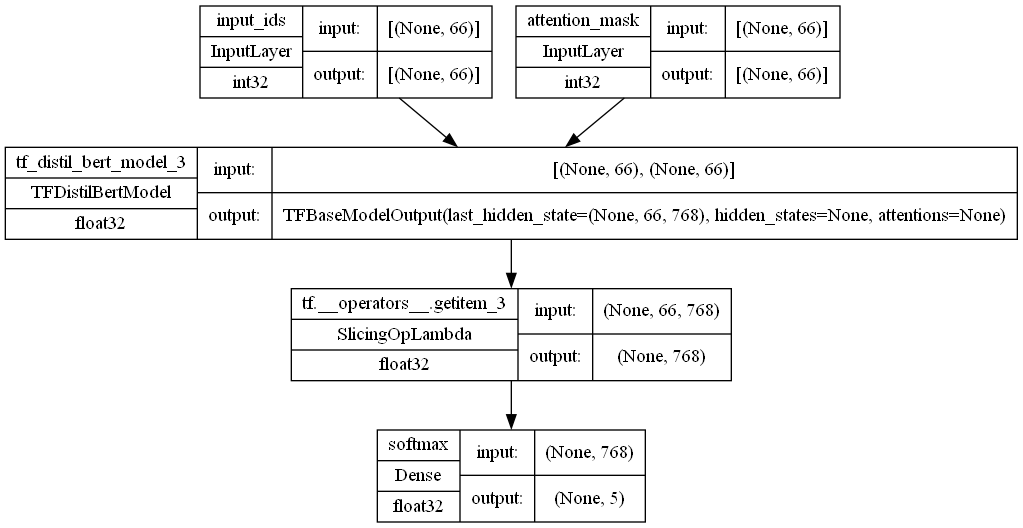

In [132]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    expand_nested=True, 
    show_dtype=True
)

In [133]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    This is only for directly working on the Huggingface models.

    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    """
    def __init__(self, runner, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        # TODO: 
        #   save_pretrained() method is in the HuggingFace model only.
        #   Need to update for custom model saving.
        self.model.save_pretrained(self.output_dir)

class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )

class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: 
        Did not work with the HuggingFace native model with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable.
        
        Did not work with the tf.keras.models.save_model nor model.save()
        as causing out-of-index errors or load_model() failures. Hence use
        save_weights_only=True.
    """
    def __init__(self, path_to_file):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True,
            save_weights_only=True,  # Cannot save entire model.
            save_freq="epoch",
            verbose=1
        )

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor="val_loss",
            factor=0.3,
            patience=patience,
            verbose=1
        )

In [134]:
def to_tensor(data, label = []):
    return tf.data.Dataset.from_tensor_slices((
    dict(tokenize(data)),  # Convert BatchEncoding instance to dictionary
    label
    )).batch(BATCH_SIZE).prefetch(1)


In [135]:
Train_Dataset = to_tensor(X_train, y_train)
Val_Dataset = to_tensor(X_val, y_val)
Test_Dataset = to_tensor(X_test, y_test)

In [136]:
print("""
MAX_SEQUENCE_LENGTH = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
L2 = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
MODEL_DIRECTORY = {}
LOG_DIRECTORY = {}
""".format(
    MAX_SEQUENCE_LENGTH,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    L2,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE,
    MODEL_DIRECTORY,
    LOG_DIRECTORY
))


MAX_SEQUENCE_LENGTH = 66
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 2e-05
L2 = 0.001
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = ../model/model
LOG_DIRECTORY = ../model/log



In [137]:
history = model.fit(
    x=Train_Dataset,    # dictionary 
    # y=Y,
    y=None,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=Val_Dataset,
    callbacks=[
        EarlyStoppingCallback(patience=EARLY_STOP_PATIENCE),
        ReduceLRCallback(patience=REDUCE_LR_PATIENCE),
        ModelCheckpointCallback(MODEL_FILE),
        TensorBoardCallback(LOG_DIRECTORY)
    ]
)

Epoch 1/5
460/460 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8487
Epoch 1: val_loss improved from inf to 0.15805, saving model to Sentiment_detection
460/460 [==============================] - 527s 1s/step - loss: 0.4245 - accuracy: 0.8487 - val_loss: 0.1580 - val_accuracy: 0.9457 - lr: 2.0000e-05
Epoch 2/5
460/460 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9603
Epoch 2: val_loss improved from 0.15805 to 0.14057, saving model to Sentiment_detection
460/460 [==============================] - 533s 1s/step - loss: 0.1111 - accuracy: 0.9603 - val_loss: 0.1406 - val_accuracy: 0.9501 - lr: 2.0000e-05
Epoch 3/5
460/460 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9697
Epoch 3: val_loss improved from 0.14057 to 0.13593, saving model to Sentiment_detection
460/460 [==============================] - 291s 631ms/step - loss: 0.0785 - accuracy: 0.9697 - val_loss: 0.1359 - val_accuracy: 0.9533 - lr: 2.0000e-05
Epoch

In [138]:
def predict(str):
    str = to_tensor(str)
    model.predict(str)

In [139]:
model.evaluate(Test_Dataset)

58/58 [==============================] - 7s 113ms/step - loss: 0.1381 - accuracy: 0.9479


[0.1381470113992691, 0.9478543996810913]

In [140]:
predict = tf.data.Dataset.from_tensor_slices((
    dict(tokenize("I love you")),
)).batch(BATCH_SIZE).prefetch(1)

In [141]:
predict = model.predict(predict)

1/1 [==============================] - 2s 2s/step


In [142]:
def predice(array):
    array = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(array)),
    )).batch(BATCH_SIZE).prefetch(1)
    return pd.DataFrame(columns=CATEGORIES,data=model.predict(array))
    

In [143]:
model.save("../AnalisisSentimental", save_format='tf')

INFO:tensorflow:Assets written to: ../AnalisisSentimental\assets


INFO:tensorflow:Assets written to: ../AnalisisSentimental\assets


In [164]:
predice("Im going to the gym")

1/1 [==============================] - 0s 125ms/step


,sadness,joy,anger,fear,surprise
0,0.001161,0.024045,0.837834,0.136693,0.000267


In [155]:
model.save_weights('../Weights')